<a href="https://colab.research.google.com/github/anthonysalvatore/comp-machine-learning-a2/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning Assignment 2: Classify Images of Cancer**

## Introduction

Within this assignment, a modified version of the 'CRCHistoPhenotypes' dataset is used to perform two major tasks being:

*   Classify cell images according to whether a given cell image represents a cancerous cell or not. 
*   Classify cell images according to cell-type.

Machine learning will be used to develop the classification systems capable of performing the afforementioned tasks. Different techniques will be explored to ultimately arrive at a model capable of performing classification to a degree that is in line with the existing literature.

## Setting environment, loading data

In [2]:
!git clone https://github.com/anthonysalvatore/comp-machine-learning-a2 # only run in colab

fatal: destination path 'comp-machine-learning-a2' already exists and is not an empty directory.


In [20]:
# load libraries
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
# load the CSV files
main_data = pd.read_csv('comp-machine-learning-a2/Image_classification_data/data_labels_mainData.csv', index_col='InstanceID') # change path if not in colab
extra_data = pd.read_csv('comp-machine-learning-a2/Image_classification_data/data_labels_extraData.csv', index_col='InstanceID')

## EDA

In [5]:
print(main_data.head())
print(extra_data.head())

            patientID  ImageName cellTypeName  cellType  isCancerous
InstanceID                                                          
22405               1  22405.png   fibroblast         0            0
22406               1  22406.png   fibroblast         0            0
22407               1  22407.png   fibroblast         0            0
22408               1  22408.png   fibroblast         0            0
22409               1  22409.png   fibroblast         0            0
            patientID  ImageName  isCancerous
InstanceID                                   
12681              61  12681.png            0
12682              61  12682.png            0
12683              61  12683.png            0
12684              61  12684.png            0
12685              61  12685.png            0


In [6]:
# display summary statistics of main_data
print(main_data.describe())
print(extra_data.describe())

         patientID     cellType  isCancerous
count  9896.000000  9896.000000  9896.000000
mean     29.762025     1.501516     0.412187
std      17.486553     0.954867     0.492253
min       1.000000     0.000000     0.000000
25%      14.000000     1.000000     0.000000
50%      26.000000     2.000000     0.000000
75%      47.000000     2.000000     1.000000
max      60.000000     3.000000     1.000000
         patientID   isCancerous
count  10384.00000  10384.000000
mean      80.38203      0.287943
std        9.40388      0.452826
min       61.00000      0.000000
25%       71.00000      0.000000
50%       81.00000      0.000000
75%       88.00000      1.000000
max       99.00000      1.000000


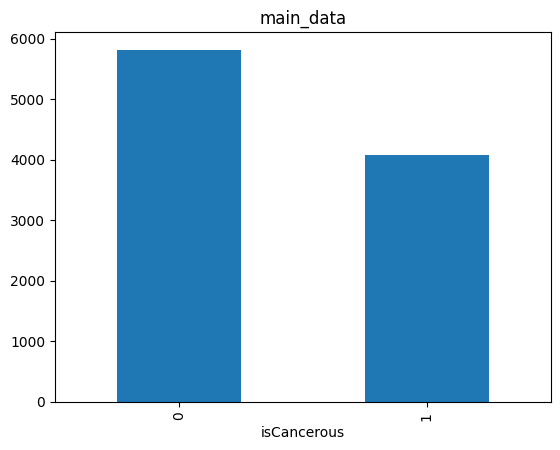

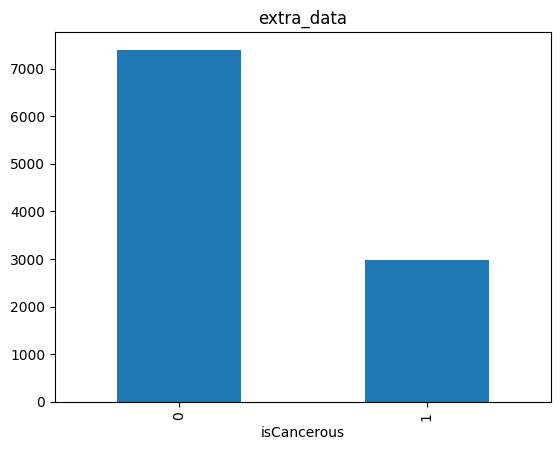

In [7]:

# visualize the distribution of isCancerous
main_data['isCancerous'].value_counts().plot(kind='bar')
plt.title('main_data')
plt.xlabel('isCancerous')
plt.show()

extra_data['isCancerous'].value_counts().plot(kind='bar')
plt.title('extra_data')
plt.xlabel('isCancerous')
plt.show()

# display a sample image
img = Image.open('comp-machine-learning-a2/Image_classification_data/patch_images/1.png')
img.show()

Main data is fairly evenly distributed between two classes. Extra data is fairly skewed though, with a ratio of about 2:1 in favour of not cancerous class.

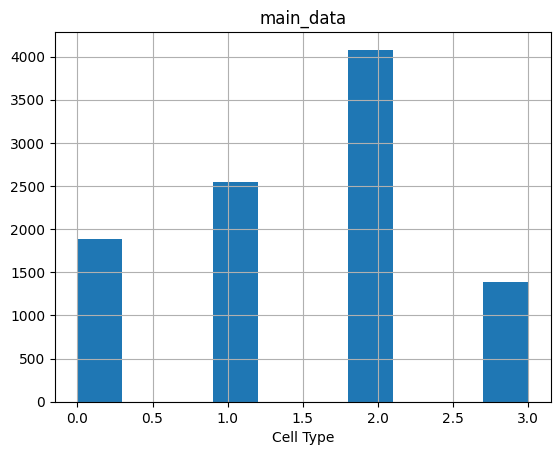

In [8]:
# visualize the distribution of cellType
main_data['cellType'].hist()
plt.title('main_data')
plt.xlabel('Cell Type')
plt.show()

The distribution above shows most images in the main_data sample are of type 2 (epithelial). The keys are as follows:
<br>
0.   fibroblast
1.   inflammatory
2.   epithelial
3.   others 

We will now plot the cell type against the isCancerous field using a stacked bar chart, to determine if there is any relationship between the two.





<Axes: xlabel='cellType'>

<Figure size 800x600 with 0 Axes>

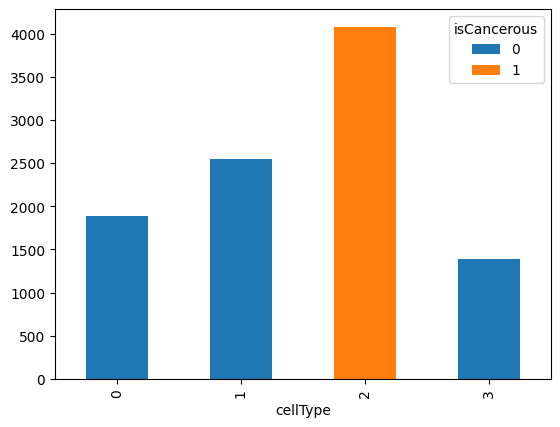

In [9]:
plt.figure(figsize=(8,6))
main_data.groupby(['cellType', 'isCancerous']).size().unstack().plot(kind='bar', stacked=True)

Visually, we can see that all cells of type 2, are cancerous, while every other type of cell is non-cancerous. We can confirm the results through a cross table:

In [10]:
table = pd.crosstab(main_data['cellType'], main_data['isCancerous'])
print(table)

isCancerous     0     1
cellType               
0            1888     0
1            2543     0
2               0  4079
3            1386     0


The cross table confirms the suspicions from the barchart, that all cancerous cells belong to the epitherial cell type. While epitherial cells are the most common type of cell in which cancers develop [1], they are obivoulsy not all cancerous cells themselves in a real-life setting. Despite this, we will be proceeding with the assumption that every cell of type 2 is cancerous as this is how the data has been presented in this case study.

## Model Development

From our EDA, we have discovered that accuracy is adequate for the task of classifying a cell as cancerous or not. This is supported by the even distribtuion of classes and the fact that it is a binary class. However, since it is often more valuable to know if a cell is cancerous rather than not in a real-world setting, the recall could also be used, to minimize the number of false negatives.
<br>
For the task of cell type classification, since there are multiple classes to predict, accuracy may not be the best metric to use. Instead, precision, recall and F1-score can be calculated for each class separately, and then averaged across all classes.
<br><br>
[pull relevant accuracy scores from literature, refer to here and set as target]
<br><br>
From the EDA, we discovered that every cell which was epitherial was cancerous. Knowing this, we can assign a label of '2' in the cellType column for each cancerous cell in the extra data dataframe.

In [11]:
extra_data.loc[extra_data['isCancerous'] == 1, 'cellType'] = 2
extra_data.loc[extra_data['isCancerous'] == 1, 'cellTypeName'] = 'epitherial'
extra_data

,patientID,ImageName,isCancerous,cellType,cellTypeName
InstanceID,,,,,
12681,61,12681.png,0,NaN,NaN
12682,61,12682.png,0,NaN,NaN
12683,61,12683.png,0,NaN,NaN
12684,61,12684.png,0,NaN,NaN
12685,61,12685.png,0,NaN,NaN
...,...,...,...,...,...
20028,99,20028.png,0,NaN,NaN
20029,99,20029.png,0,NaN,NaN
20030,99,20030.png,0,NaN,NaN


After applying the change to the extra data dataframe, we can merge it with the main data dataframe. Using both the main and extra data is well justified in the case of classifying isCancerous since both contain the full data needed. The extra data dataframe can supplement the main data in the case of cellType classification, as it now contains some data pertaining to cellType. However, since we were only able to discern epitherial cells from our EDA, the data is likely to be heavily skewed towards cellType 2 and may cause the classifier to have more of a bias for classifying cells as belonging to cell type 2. This will be explored further throughout the report. After merging the dataframes, a distribution of cell types can be seen in the graph below.

In [12]:
df = pd.concat([main_data, extra_data]).sort_index()
df

,patientID,ImageName,cellTypeName,cellType,isCancerous
InstanceID,,,,,
1,36,1.png,fibroblast,0.0,0
2,36,2.png,fibroblast,0.0,0
3,36,3.png,fibroblast,0.0,0
4,36,4.png,fibroblast,0.0,0
5,36,5.png,fibroblast,0.0,0
...,...,...,...,...,...
22438,27,22438.png,others,3.0,0
22439,27,22439.png,others,3.0,0
22442,27,22442.png,others,3.0,0


<Axes: >

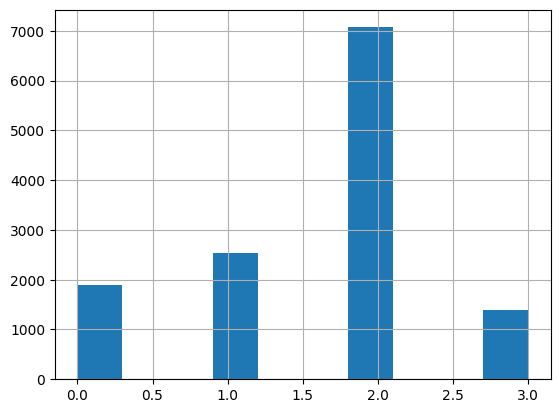

In [13]:
df['cellType'].hist()

As expected, imputing a value of 2 for each cellType in the extra data dataframe that contained a cancerous cell has further inbalanced the classes within this field.
<br><br>
We will now create two datasets off of the merged dataframe to perform each of the two classification tasks required. This is necessary since we have missing values in our cellType and cellTypeName column so we need to distinguish between the two before we perform a split. We also drop all unnecessary columns here for each dataframe. Only the labels and image name are needed for model training purposes.

In [14]:
df_cancerous = df.drop(['patientID', 'cellTypeName', 'cellType'], axis=1)
df_type = df.dropna().drop(['patientID', 'cellTypeName', 'isCancerous'], axis=1)

In [15]:
print(df_cancerous)
print(df_type)

            ImageName  isCancerous
InstanceID                        
1               1.png            0
2               2.png            0
3               3.png            0
4               4.png            0
5               5.png            0
...               ...          ...
22438       22438.png            0
22439       22439.png            0
22442       22442.png            0
22443       22443.png            0
22444       22444.png            0

[20280 rows x 2 columns]
            ImageName  cellType
InstanceID                     
1               1.png       0.0
2               2.png       0.0
3               3.png       0.0
4               4.png       0.0
5               5.png       0.0
...               ...       ...
22438       22438.png       3.0
22439       22439.png       3.0
22442       22442.png       3.0
22443       22443.png       3.0
22444       22444.png       3.0

[12886 rows x 2 columns]


We now have a clean dataframe for each classification task, containing no missing values.
<br><br>
Next, we split each dataframe into test, validation and training sets to be used for model training, validation and testing respectively. Here we choose a standard 60/20/20 split

In [16]:
# train/val/test split for both dataframes
train_data_c, test_data_c = train_test_split(df_cancerous, test_size=0.2, random_state=42)
train_data_c, val_data_c = train_test_split(train_data_c, test_size=0.25, random_state=42)

train_data_t, test_data_t = train_test_split(df_type, test_size=0.2, random_state=42)
train_data_t, val_data_t = train_test_split(train_data_t, test_size=0.25, random_state=42)

print("Cancerous train data : {}, Cancerous val data: {}, Cancerous test data: {}".format(train_data_c.shape[0], val_data_c.shape[0], test_data_c.shape[0]))
print("Cell type train data : {}, Cell type val data: {}, Cell type test data: {}".format(train_data_t.shape[0], val_data_t.shape[0], test_data_t.shape[0]))

Cancerous train data : 12168, Cancerous val data: 4056, Cancerous test data: 4056
Cell type train data : 7731, Cell type val data: 2577, Cell type test data: 2578


Text(0.5, 1.0, 'Cancerous Dataset')

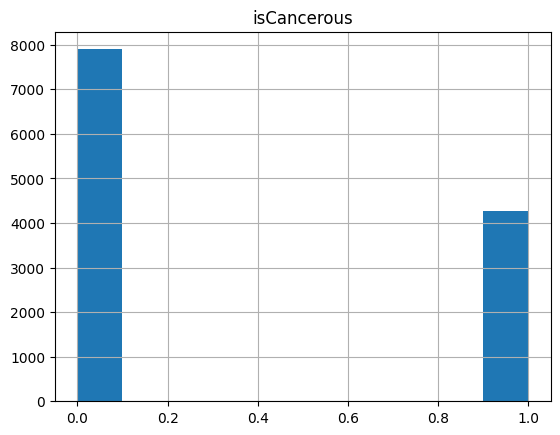

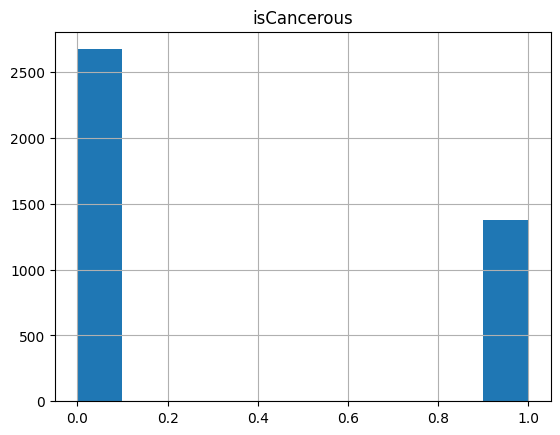

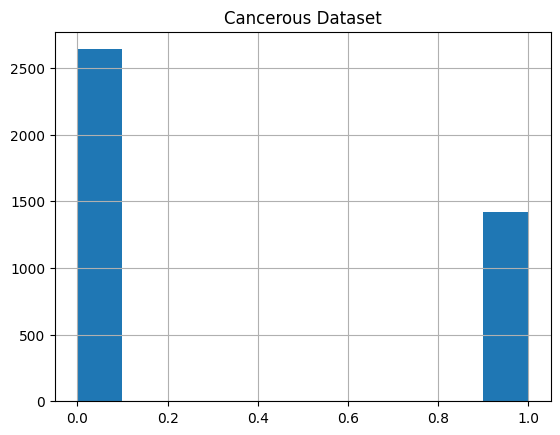

In [18]:
train_data_c.hist()
val_data_c.hist()
test_data_c.hist()

array([[<Axes: title={'center': 'cellType'}>]], dtype=object)

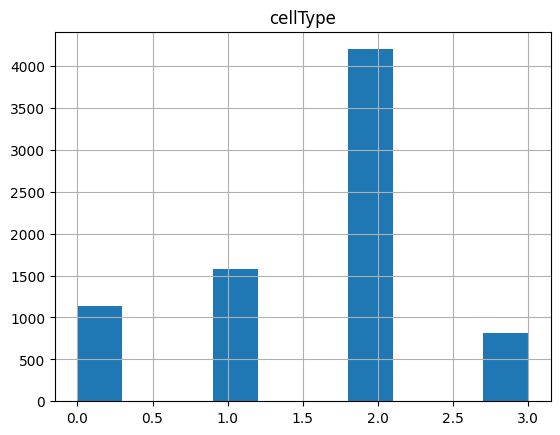

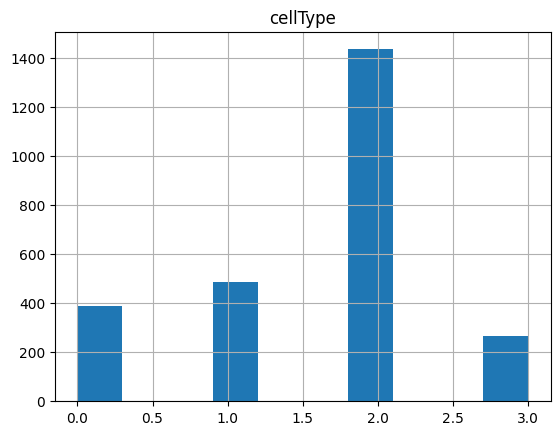

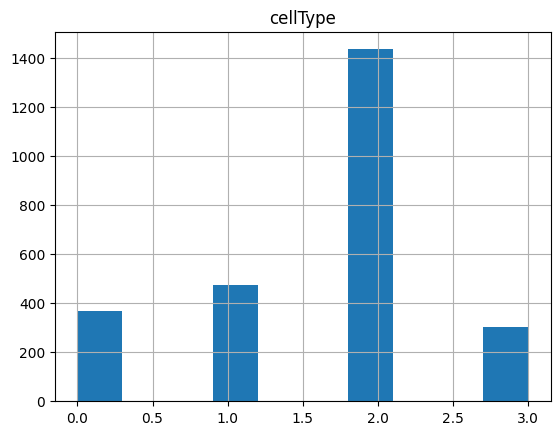

In [23]:
train_data_t.hist()
val_data_t.hist()
test_data_t.hist()

Distribution appears fairly similar between train/test/val for all pairings.
<br>
Since this is an image classification problem, a neural network works very well on the non-linear and huge number of parameters of an image. Since we intend to use neural networks for this project, a method of evaluating the rate of learning of the network is necessary so we can decide on next-step actions. We can plot the learning curve of the NN training process using the function below. This function will serve as our diagnostic tool.


In [ ]:
# code taken from [2]
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

## Baseline Model

We require a baseline model as our initial solution. We will iterate over this model throughout remainder of the project, exploring different avenues that can lead to improvements. We will initially use an multi-layer perceptron (MLP) model and later promote this basic model to the more complex convolutional neural network (CNN).
<br><br>
We need to set some initial parameters for our NN, pertaining to the input dimension, hidden layer dimension and number of classes to output. We will define these parameters below for both of our two classification problems. The hidden layer hyper parameter can be tuned later but will be set at 256 for both initially. 256 represents the value each RGB chanel can range from, so is a fair initial estimate here.

In [22]:
INPUT_DIM_c = (27,27,3)
HIDDEN_LAYER_DIM_c = 256
OUTPUT_CLASSES_c = 2

INPUT_DIM_t = (27,27,3)
HIDDEN_LAYER_DIM_t = 256
OUTPUT_CLASSES_t = 4

With the above parameters defined, we can begin to build out the model. For this, we will use the popular machine learning library tensorflow, specifically the API keras which provides a Python interface for artificial neural networks. We work in layers, building our neural network up in a number of interconnected layers, defined by our set parameters.
<br> We use the sequential API as it is the simplest.

In [30]:
model_c = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM_c),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM_c),
    tf.keras.layers.Dense(OUTPUT_CLASSES_c)
])

model_t = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM_t),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM_t),
    tf.keras.layers.Dense(OUTPUT_CLASSES_t)
])

The first layer transforms the images from a two dimensional image array, to a one dimensional array (27 * 27 * 3 = 2187 px). The next two layers are densely connected neural layers, with the last being related to the class to be classified for each problem.
<br><br>
model.summary() can print a brief summary of the model that we have created.

In [31]:
model_c.summary()
model_t.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 2187)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               560128    
                                                                 
 dense_9 (Dense)             (None, 2)                 514       
                                                                 
Total params: 560,642
Trainable params: 560,642
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 2187)              0         
                                                                 
 dense_10 (Dense)         

tf.keras.utils.plot_model can present the model as a figuire

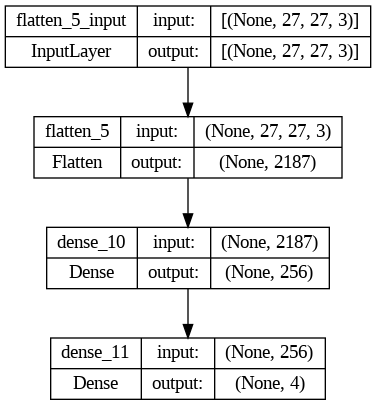

In [34]:
tf.keras.utils.plot_model(model_c, show_shapes=True)
tf.keras.utils.plot_model(model_t, show_shapes=True)

## References

[1] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3927155/#:~:text=Epithelial%20tissue%20is%20also%20the,percent%20of%20all%20human%20cancers.<br>
[2] [link course notes]